In [3]:
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torch.utils.data import random_split

from torch.optim import AdamW
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from transformers import ViTImageProcessor, ViTModel
from sklearn.metrics import confusion_matrix, f1_score
import torch.utils.data as data_utils

In [234]:
class MuseumDataset(torch.utils.data.Dataset):
    """Датасет с фотками музея."""
    def __init__(self, csv_file, root_dir, transform=None):
        super(MuseumDataset, self).__init__()
        self.museum_items = pd.read_csv(csv_file, sep = ';', encoding = 'utf-8')
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = self.museum_items['group'].unique()
        
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = os.path.join(self.root_dir, 
                                str(self.museum_items.iloc[idx, 0]), self.museum_items.iloc[idx, 4])

        image = Image.open(img_file)
        items = self.museum_items.iloc[idx, 3]
        if image.mode != "RGB":
            image = image.convert(mode="RGB")
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'class': items}
        
        class_idx = np.where(self.class_names == sample['class'])[0][0]
        class_name = torch.tensor(class_idx)

        return sample['image'], class_name


    def __len__(self):
        return len(self.museum_items)


In [231]:
class MyViTWithMLP(nn.Module):
    def __init__(self, vit_model, num_classes=15):
        super(MyViTWithMLP, self).__init__()
        self.vit_model = vit_model
        self.hidden_size = vit_model.config.hidden_size
        self.mlp_head = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.vit_model(x)
        output = self.mlp_head(features.last_hidden_state[:, 0])
        return output

In [19]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for batch_idx, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)

    inputs = processor(images=images, return_tensors="pt").to(device)

    
    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
torch.save(last_hidden_states, 'last_hidden_states3.pt')

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


torch.Size([3, 224, 224]) tensor(3)
['Археология' 'Оружие' 'Прочие' 'Нумизматика' 'Фото, негативы'
 'Редкие книги' 'Документы' 'Печатная продукция' 'ДПИ' 'Скульптура'
 'Графика' 'Техника' 'Живопись' 'Естественнонауч.коллекция' 'Минералогия']


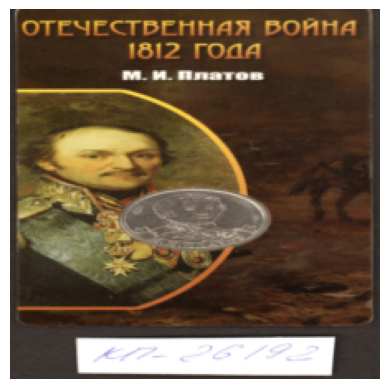

In [4]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),  # изменение размера изображения на 224x224 пикселей
    transforms.ToTensor(),
])


df_train = MuseumDataset("train_dataset_mincult-train/train.csv", os.path.join(os.getcwd(), "train_dataset_mincult-train", "train"), trans)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_size = int(0.8 * len(df_train))  
test_size = len(df_train) - train_size  

train_dataset, test_dataset = random_split(df_train, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


image_batch, label_batch = next(iter(train_dataloader))


image, label = image_batch[0], label_batch[0]


print(image.shape, label)
print(df_train.class_names)
plt.imshow(image.permute(1, 2, 0))
plt.axis(False);



In [8]:
model_path = 'vit3'

model = ViTModel.from_pretrained(model_path)
model = model.to(device)
classifier2 = MyViTWithMLP(model, num_classes=15)
classifier2 = classifier2.to(device)

In [9]:
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(classifier2.parameters(), lr=5e-5)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        images, labels = batch
        labels = torch.tensor(labels).to(device)

        images = images.to(device)

        outputs = classifier2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_dataloader)}")

  0%|          | 0/2035 [00:00<?, ?it/s]

C:\Users\kapit\AppData\Local\Temp\ipykernel_27204\1209446623.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 1/3, Loss: 1.013535261443411


  0%|          | 0/2035 [00:00<?, ?it/s]

Epoch 2/3, Loss: 0.39528506477786735


  0%|          | 0/2035 [00:00<?, ?it/s]

Epoch 3/3, Loss: 0.20991742353547704


In [10]:
torch.save(classifier2.state_dict(), 'classifier2.pth')

In [11]:
num_more_epochs = 2
for epoch in range(num_epochs + 1, num_epochs + num_more_epochs + 1):
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader)
    for batch in progress_bar:
        images, labels = batch
        labels = torch.tensor(labels).to(device)

        images = images.to(device)

        outputs = classifier2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch}/{num_epochs + num_more_epochs}, Loss: {epoch_loss}")

  0%|          | 0/2035 [00:00<?, ?it/s]

C:\Users\kapit\AppData\Local\Temp\ipykernel_27204\1851145757.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 4/5, Loss: 244.07635032234248


  0%|          | 0/2035 [00:00<?, ?it/s]

Epoch 5/5, Loss: 178.39653215405997


In [12]:
torch.save(classifier2.state_dict(), 'classifier_final.pth')

In [13]:
print("Epoch 4/5, Loss:", 244.07635032234248/len(train_dataloader))
print("Epoch 5/5, Loss:", 178.39653215405997/len(train_dataloader))

Epoch 4/5, Loss: 0.11993923848763759
Epoch 5/5, Loss: 0.08766414356464863


In [17]:
classifier2.train()
epoch_loss = 0.0
progress_bar = tqdm(train_dataloader)
for batch in progress_bar:
    images, labels = batch
    labels = torch.tensor(labels).to(device)

    images = images.to(device)

    outputs = classifier2(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    progress_bar.set_postfix({'loss': loss.item()})

print(f"Epoch {epoch}/{num_epochs + num_more_epochs}, Loss: {epoch_loss/len(train_dataloader)}")

  0%|          | 0/2035 [00:00<?, ?it/s]

C:\Users\kapit\AppData\Local\Temp\ipykernel_27204\1817178932.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 5/5, Loss: 0.0668969276419232


In [19]:
classifier2.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        images, labels = batch
        labels = torch.tensor(labels).to(device)

        images = images.to(device)

        outputs = classifier2(images)

        _, predicted = torch.max(outputs, 1)
        y_true += labels.cpu().tolist()
        y_pred += predicted.cpu().tolist()


conf_mat = confusion_matrix(y_true, y_pred)
f1_scores = f1_score(y_true, y_pred, average='weighted')


print(f"Weighted F1 Score: {f1_scores}")

C:\Users\kapit\AppData\Local\Temp\ipykernel_27204\1003505790.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Weighted F1 Score: 0.8439943869543417


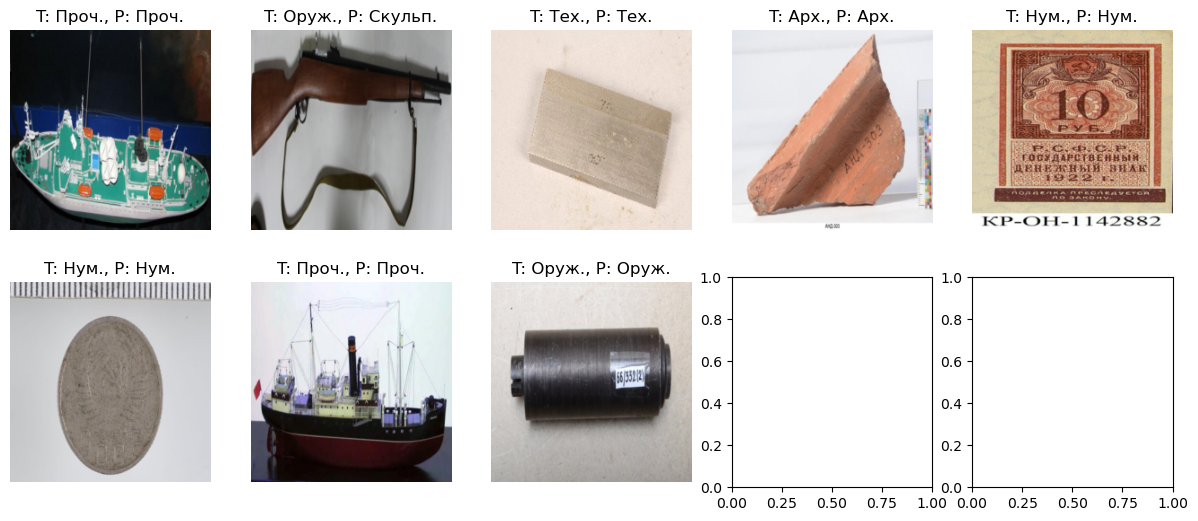

In [115]:
random_sampler = data_utils.RandomSampler(test_dataset)

random_dataloader = data_utils.DataLoader(test_dataset, batch_size=8, sampler=random_sampler)

# a = ['Археология', 'Оружие', 'Прочие', 'Нумизматика', 'Фото, негативы',
#  'Редкие книги', 'Документы', 'Печатная продукция', 'ДПИ', 'Скульптура',
#  'Графика', 'Техника', 'Живопись', 'Естественнонауч.коллекция', 'Минералогия']
a = ['Арх.', 'Оруж.', 'Проч.', 'Нум.', 'Фот.', 'Р.кн.', 'Док.', 'Печ.пр.', 'ДПИ', 'Скульп.', 'Граф.', 'Тех.', 'Живоп.', 'Ест.н.к.', 'Мин.']

for batch in random_dataloader:
    images, labels = batch
    break  
images = images.to(device)


with torch.no_grad():
    outputs = classifier2(images)
    _, predicted = torch.max(outputs, 1)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(8):
    ax = axs[i // 5, i % 5]
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    ax.set_title(f"T: {a[labels[i]]}, P: {a[predicted[i]]}")
    ax.axis('off')

plt.show()

In [20]:
torch.save(classifier2.state_dict(), 'classifier_final2.pth')

In [248]:
def predict_image_class(image):
    Vmodel = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
    model = MyViTWithMLP(Vmodel).to(device)
    weights_path = 'classifier_final2.pth'
    model.load_state_dict(torch.load(weights_path))
    if image != 'RGB':
        image.convert("RGB")
    im_classes = ['Археология', 'Оружие', 'Прочие', 'Нумизматика', 'Фото, негативы',
  'Редкие книги', 'Документы', 'Печатная продукция', 'ДПИ', 'Скульптура',
  'Графика', 'Техника', 'Живопись', 'Естественнонауч.коллекция', 'Минералогия']
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval() 
        output = model(input_tensor)

    probabilities = torch.softmax(output, dim=1)[0]
    predicted_class_index = torch.argmax(probabilities).item()

    return im_classes[predicted_class_index]

In [163]:
foimage_path = 'train_dataset_mincult-train/train/13730958/12038461.jpg'#носок
image_path2 = 'train_dataset_mincult-train/train/14034387/12416129.jpg'#книга
image_path3 = 'train_dataset_mincult-train/train/15031741/13817143.jpg'#живопись
image = Image.open(image_path).convert("RGB")
predicted_class = predict_image_class(image)

print('Predicted class:', predicted_class)

Predicted class: Прочие


In [251]:
class MuseumDataset(torch.utils.data.Dataset):
    """Датасет с фотками музея."""
    def __init__(self, csv_file, root_dir, transform=None):
        super(MuseumDataset, self).__init__()
        self.museum_items = pd.read_csv(csv_file, sep = ';', encoding = 'utf-8')
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = self.museum_items['group'].unique()
        
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = os.path.join(self.root_dir, 
                                str(self.museum_items.iloc[idx, 0]), self.museum_items.iloc[idx, 2])

        image = Image.open(img_file)

        return image, idx


    def __len__(self):
        return len(self.museum_items)
test_dataset = MuseumDataset("test_dataset_mincult-test/subm_test.csv", os.path.join(os.getcwd(), "test_dataset_mincult-test", "test"), transform)

predicted_classes = []
for image, idx in test_dataset[2751:len(test_dataset)]:
    predicted_class = predict_image_class(image)
    test_dataset.museum_items.loc[idx, 'group'] = predicted_class

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'Series'

In [247]:
print(len(predicted_classes))
print(predicted_classes[:10])

2751
['Археология', 'Археология', 'Археология', 'ДПИ', 'Археология', 'Прочие', 'Археология', 'Археология', 'Археология', 'Археология']


In [250]:
test_dataset.museum_items.to_csv("test_dataset_mincult-test/subm_test_predicted.csv", sep=';', encoding = 'utf-8',  index=False)

In [224]:
# class MuseumDataset(torch.utils.data.Dataset):
#     """Датасет с фотками музея."""
#     def __init__(self, csv_file, root_dir, transform=None):
#         super(MuseumDataset, self).__init__()
#         self.museum_items = pd.read_csv(csv_file, sep = ';', encoding = 'utf-8')
#         self.root_dir = root_dir
#         self.transform = transform
#         self.class_names = self.museum_items['group'].unique()
#         #self.class_names = ['Археология', 'Оружие', 'Прочие', 'Нумизматика', 'Фото, негативы',
#   #'Редкие книги', 'Документы', 'Печатная продукция', 'ДПИ', 'Скульптура',
#   #'Графика', 'Техника', 'Живопись', 'Естественнонауч.коллекция', 'Минералогия']
        
        
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_file = os.path.join(self.root_dir, 
#                                 str(self.museum_items.iloc[idx, 0]), self.museum_items.iloc[idx, 2])

#         image = Image.open(img_file)
#         items = self.museum_items.iloc[idx, 1]
#         if image.mode != "RGB":
#             image = image.convert(mode="RGB")
#         if self.transform:
#             image = self.transform(image)
#         sample = {'image': image, 'class': }
    
#         return sample['image'], sample['class']


#     def __len__(self):
#         return len(self.museum_items)
    



In [225]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

df_test= MuseumDataset("test_dataset_mincult-test/subm_test.csv", os.path.join(os.getcwd(), "test_dataset_mincult-test", "test"), trans)

sample = df_test[0]
print(sample)
# Извлекаем изображение и метку класса
image, class_idx = sample['image'], sample['class']
print(image)

# Выводим изображение
plt.imshow(image.permute(1, 2, 0))  # Переводим тензор обратно в формат изображения
plt.title(f"Class: {class_idx}")
plt.axis('off')
plt.show()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

test_dataset = df_test

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
# for batch in test_dataloader:
#     images, labels = batch
#     # labels = torch.tensor(labels).to(device)

#     # images = images.to(device)

#     # outputs = classifier2(images)

# image_batch, label_batch = next(iter(test_dataloader))


# image, label = image_batch[0], label_batch[0]


# print(image.shape, label)
# print(df_test.class_names)
# plt.imshow(image.permute(1, 2, 0))
# plt.axis(False);



(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1

TypeError: tuple indices must be integers or slices, not str

In [180]:
# classifier2.eval()

# y_true = []
# y_pred = []
# with torch.no_grad():
#     for batch in test_dataloader:
#         images, labels = batch
#         labels = torch.tensor(labels).to(device)

#         images = images.to(device)

#         outputs = classifier2(images)

#         _, predicted = torch.max(outputs, 1)
#         y_true += labels.cpu().tolist()
#         y_pred += predicted.cpu().tolist()


# conf_mat = confusion_matrix(y_true, y_pred)
# f1_scores = f1_score(y_true, y_pred, average='weighted')


# print(f"Weighted F1 Score: {f1_scores}")

IndexError: index 3 is out of bounds for axis 0 with size 3